# AI　Workshop 2021/09 第３章ラベリング
by tsuchida

> 各Functionはこちらのものを少しバグを治して、利用しています。
> https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/src/features/snippets.py

> **為替の日足クローズ値　USD／JPYのレートを使用します。**

### 目的:機械学習の学習で予測の精度をあげるために、データの中から必要な情報を抽出し、ラベリングするラベリング方法を学習する


### 前処理　以下のデータ取得して整形しています　　みずほ銀行　マーケットデータより

参照：https://www.mizuhobank.co.jp/market/quote.csv
 

ライブラリのインポート

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from datetime import datetime

import requests
import io

データの取得と整形

In [147]:
# データダウンロード
url = 'https://www.mizuhobank.co.jp/market/quote.csv'
res = requests.get(url)
df_tmp = pd.read_csv(io.BytesIO(res.content), encoding='shift-jis', sep=",")

# データを整形
df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: 'Date'})
df_tmp = df_tmp.rename(columns={df_tmp.columns[1]: 'USD'})
df_tmp = df_tmp.drop(0, axis=0)
df_tmp = df_tmp.drop(1, axis=0)

close = pd.Series(df_tmp['USD'].tolist(), index=pd.to_datetime(df_tmp['Date']).tolist())
close = close[:].astype(float)
#print(close)

グラフ表示処理初期値の設定

In [148]:
# グラフ表示の初期値の設定
ymin = 99
ymax = 122
sxmin='2016-01-01'
sxmax=close.index.max().strftime('%Y-%m-%d')
xmin = datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.strptime(sxmax, '%Y-%m-%d')
figure_size = (22, 8)


取得データの整形とグラフの表示

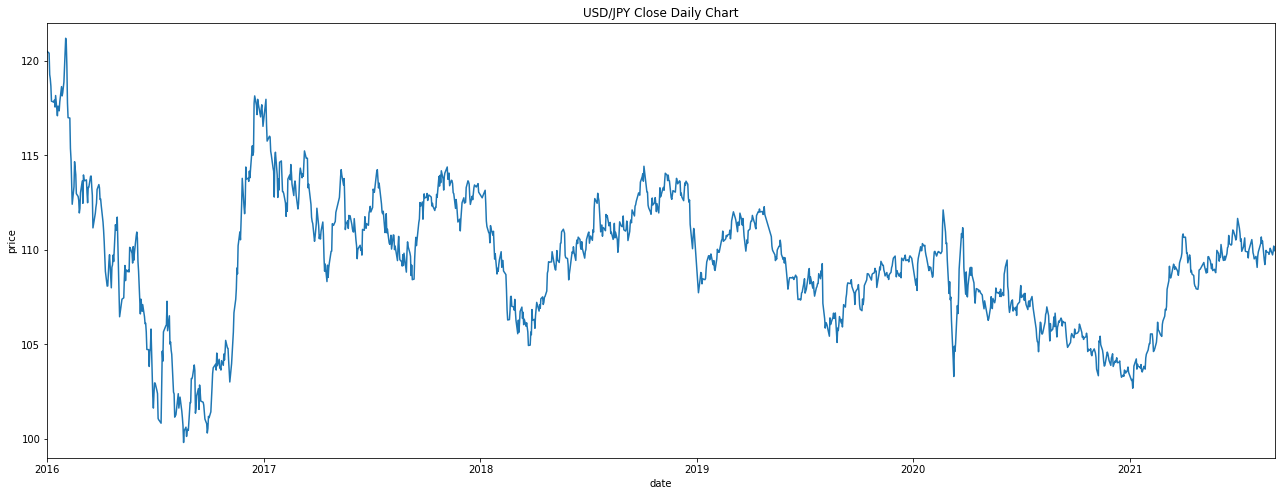

In [149]:
plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.title("USD/JPY Close Daily Chart")
plt.xlabel('date')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.ylabel('price')

plt.show()

###2. ラベリングを行う際に利用する初期値を設定する

In [150]:

# ラベリングの初期値の設定
# numDays
numDays = 1
# バリアの幅
ptsl = [ 1,1 ]
# 目標リターン
minRate = 0.009
#. 不要なラベルを削除するための閾値
minPct = 0.0005
# 
cpus = 1

##1. Functionの紹介

###1.1 CUSUMフィルタ　Function

**前日と当日のレートの差をとり、売買いずれかの方向それぞれに差を蓄積し、
閾値を超えた場合にイベントとしてそのデータの日付を返す**


> input  : close = 日足の終値(pandas Series), h=閾値(float)

> output : tEvent = 閾値を超えた日付の配列(list)


In [31]:
# =======================================================
# Symmetric CUSUM Filter [2.5.2.1]
def getTEvents(gRaw, h):
    """cusum filter
    args
    ----
        gRaw: array-like
        h: int() or float()
    returns
    -------
        pd.DatetimeIndex()
    """
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna().abs()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break

        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)


###1.2 日次ボラティリティ　Function

**指定した区間の日足の情報のボラティリティを計算して値を出力する**

**指数加重移動平均を使った標準偏差の値が出力される**

<指数加重移動平均>
重みは指数関数的に減少するので、最近のデータを重視するとともに古いデータを完全には切り捨てない


> input  : close = 日足の終値(pandas Series) span0=ボラティリティを求める期間(int)

> output : df0 = 日次ボラティリティ(dataframe)


In [32]:
# =======================================================
# Daily Volatility Estimator [3.1]
## for wtvr reason dates are not aligned for return calculation
## must account for it for computation

def getDailyVol(close,span0=10):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

###1.3 時間バリア　Function

**トリプルバリアの有効期限を取得する**

> input  : tEvents = イベント日付(トリプルバリアの起点) ,close = 日足の終値(pandas Series), numDays=イベント発生した後の有効期限(int)

> output : t1 = トリプルバリアの時間の有効期限(dataframe)

In [43]:
# =======================================================
# Adding Vertical Barrier [3.4]
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1


###1.4トリプルバリア　Function : getEventsOld

メタラベリングなし(売買しない判断なし)

**トリプルバリア法で売買ラベリングを取得する**

> input : close=日足の終値(pandas Series)  , tEvents=CUSUMフィルタで求めた日付の配列(list) , ptSl=上下バリアの閾値(list) , trgt=日次ボラティリティ(dataframe) , minRet= , numThreads=スレッドの数(int), t1=トリプルバリアの有効期限の値(dataframe)

> output : out=トリプルバリア(dataframe)

In [44]:
# ****. トリプルバリア　Function メタラベリングなし*****
# =======================================================
# Gettting Time of First Touch (getEvents) [3.3]
def getEventsOld(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
      t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    side_=pd.Series(1.,index=trgt.index)
    
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl)
    print(type(df0))
    events['t1']=df0.dropna(how='all').min(axis=1) 
    events=events.drop('side',axis=1)
    return events

In [45]:
# =======================================================
# Triple-Barrier Labeling Method [3.2]
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)

    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

### トリプルバリアで利用するFunction

In [46]:
# =======================================================
# multiprocessing snippet [20.7]
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)

    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out

    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

In [47]:
# =======================================================
# Linear Partitions [20.4.1]
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [48]:
# =======================================================
# single-thread execution for debugging [20.8]
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

In [49]:
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

In [50]:
# =======================================================
# Unwrapping the Callback [20.10]
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

###1.5 サイドとサイズのラベリング　Function：getBinsOld

**サイドとサイズのラベリングを取得する**
(売買しない判断なし)

> input : events=トリプルバリアの情報(dataframe), close=日足の終値(pandas Series)

> output : out=サイドとサイズのラベリングデータ(dataframe)

In [41]:
# =======================================================
# Expanding getBins to Incorporate Meta-Labeling [3.5]
def getBinsOld(events, close):
    '''
    Compute event's outcome.
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    return out

###1.6 不要なラベルの削除　Function：dropLabels

**サイズとサイドのラベリングで取得した値から閾値により小さいラベルを削除する**

> input : events=サイドとサイズのラベリング(dataframe) minPct=削除するための閾値

> output : out=削除後のサイドとサイズのラベリングデータ(dataframe)

In [51]:
# =======================================================
# Dropping Unnecessary Labels [3.8]
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        #print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

###1.7 トリプルバリア　Function：getEvents

メタラベリングあり(売買しない判断あり)

**トリプルバリア法で売買ラベリングを取得する**

> input : close=日足の終値(pandas Series)  , tEvents=CUSUMフィルタで求めた日付の配列(list) , ptSl=上下バリアの閾値(list) , trgt=日次ボラティリティ(dataframe) , minRet= , numThreads=スレッドの数(int), t1=トリプルバリアの有効期限の値,side=トリプルバリアで求めた売買の情報(dataframe)

> output : out=トリプルバリア(dataframe)

In [199]:
# =======================================================
# Gettting Time of First Touch (getEvents) [3.6]
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads,t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
      t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1 
    print("target:")
    print(type(trgt.index))
    print(trgt.index)

    if side is None:
      side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
      side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) #pd.min ignores nan
    
    if side is None:
      events=events.drop('side',axis=1)

    return events
# =======================================================

###1.8 サイドとサイズのラベリング　Function：getBins

**サイドとサイズのラベリングを取得する (売買しない判断なし)**

> input : events=トリプルバリアの情報(dataframe), close=日足の終値(pandas Series)

> output : out=サイドとサイズのラベリングデータ(dataframe)

In [191]:
# =======================================================
# Labeling for side and size [3.5, 3.8]
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1

    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

##2 メタラベリングなしの処理

###2.1 CUSUMフィルターでイベントを取得する

閾値はUSD/JPYレートの標準偏差を求めて利用している

CUSUMフィルターではレートの差を利用している為、単位を合わせるために値を修正




h1:
0.01260107541264109


100%|██████████| 4760/4760 [00:00<00:00, 18757.91it/s]


tEvents:
DatetimeIndex(['2002-04-10', '2002-04-16', '2002-04-19', '2002-04-25',
               '2002-05-02', '2002-05-08', '2002-05-13', '2002-05-16',
               '2002-05-20', '2002-05-22',
               ...
               '2021-06-17', '2021-06-28', '2021-07-05', '2021-07-09',
               '2021-07-15', '2021-07-27', '2021-08-04', '2021-08-11',
               '2021-08-16', '2021-08-26'],
              dtype='datetime64[ns]', length=1270, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
close event:4762
csum  event:1270


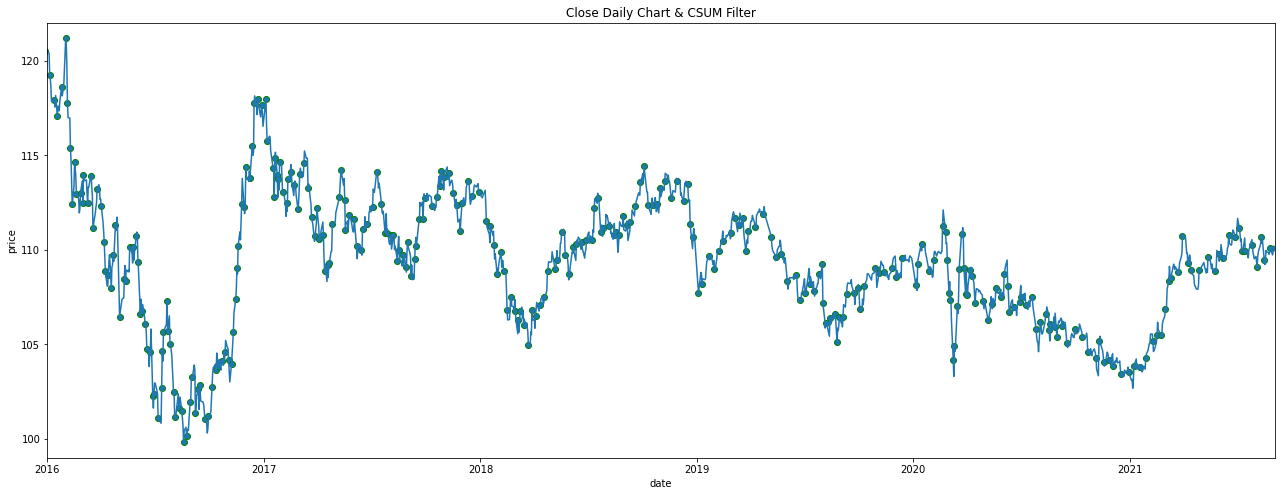

In [192]:
#CSUMフィルターの閾値としてレートの標準差を利用してするための処理
h1 = close.std()/1000
print("h1:")
print(h1)

# CUSUMフィルター　閾値を超えた時をイベントとして取得する
tEvents = getTEvents(close,h=h1)
print("tEvents:")
print(tEvents)
print(type(tEvents))

cusum_price = close[close.index.isin(tEvents)]
#print("cusum_price:")
#print(cusum_price)

print("close event:" + str(len(close.index)))
print("csum  event:" + str(len(cusum_price.index)))

plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.scatter(cusum_price.index, cusum_price[:],edgecolors="green")
plt.title("Close Daily Chart & CSUM Filter")
plt.xlabel('date')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.ylabel('price')

plt.show()

###2.2 日次ボラティリティと垂直バリア情報を取得する

In [193]:
print("numDays:" + str(numDays))

# 日次ボラティリティを計算する
dailyvola = getDailyVol(close,10)
#print("dailyvola:")
target=dailyvola[1:]
print(target)
print(type(target))

# 垂直バリアの情報を追加する
t1 = addVerticalBarrier(tEvents,close,numDays=2)

print(t1 )

numDays:1
2002-04-04    0.000796
2002-04-05    0.003973
2002-04-08    0.003435
2002-04-09    0.002973
2002-04-10    0.002716
                ...   
2021-08-30    0.003813
2021-08-31    0.003471
2021-09-01    0.003614
2021-09-02    0.003270
2021-09-03    0.003198
Name: dailyVol, Length: 4759, dtype: float64
<class 'pandas.core.series.Series'>
2002-04-10   2002-04-12
2002-04-16   2002-04-18
2002-04-19   2002-04-22
2002-04-25   2002-04-30
2002-05-02   2002-05-07
                ...    
2021-07-27   2021-07-29
2021-08-04   2021-08-06
2021-08-11   2021-08-13
2021-08-16   2021-08-18
2021-08-26   2021-08-30
Length: 1270, dtype: datetime64[ns]


###2.3 売買をラベリングする

<class 'pandas.core.frame.DataFrame'>
labels:
                 ret  bin
2002-04-10  0.003060  1.0
2002-04-16 -0.006826 -1.0
2002-04-19  0.001537  1.0
2002-04-25 -0.005407 -1.0
2002-05-02 -0.003531 -1.0
...              ...  ...
2021-07-27 -0.004807 -1.0
2021-08-04  0.005501  1.0
2021-08-11 -0.001897 -1.0
2021-08-16  0.000457  1.0
2021-08-26 -0.003180 -1.0

[1270 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
close event:4762
cusum event:1270
buy   event:647
sell  event:612


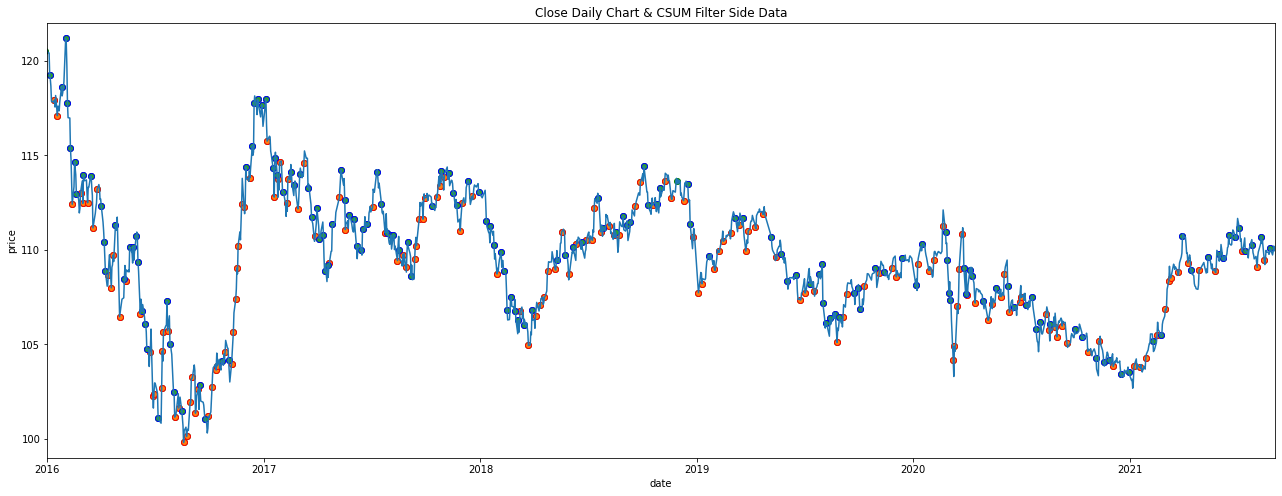

In [217]:
# トリプルバリアのイベントを取得する
events = getEventsOld(close,tEvents,ptsl,target,minRate,cpus,t1=t1)
#print("events:")
#print(events)

# 売買の方向を示す　メタラベリングがないパターン
labels = getBinsOld(events,close)
print("labels:")
print(labels)
print(type(labels))

# 不要なラベリングの削除
clean_labels = dropLabels(labels,minPct)
event_price = close[close.index.isin(clean_labels.index)]

clean_labels_buy = clean_labels.query('bin == 1')
event_price_buy = close[close.index.isin(clean_labels_buy.index)]
#print("event_price_buy:")
#print(event_price_buy)

clean_labels_sell = clean_labels.query('bin == -1')
event_price_sell = close[close.index.isin(clean_labels_sell.index)]
#print("event_price_sell:")
#print(event_price_sell)

print("close event:" + str(len(close.index)))
print("cusum event:" + str(len(cusum_price.index)))
print("buy   event:" + str(len(event_price_buy.index)))
print("sell  event:" + str(len(event_price_sell.index)))

# グラフ表示
plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.scatter(cusum_price.index, cusum_price[:],edgecolors="green")
plt.scatter(event_price_buy.index, event_price_buy[:],edgecolors="red")
plt.scatter(event_price_sell.index, event_price_sell[:],edgecolors="blue")
plt.title("Close Daily Chart & CSUM Filter Side Data")
plt.xlabel('date')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.ylabel('price')

plt.show()

##3. メタラベリングありの処理

###3.1 メタラベリング

取引を行うか行わないかをラベリングする

side:
2002-04-10    1.0
2002-04-16   -1.0
2002-04-19    1.0
2002-04-25   -1.0
2002-05-02   -1.0
             ... 
2021-07-27   -1.0
2021-08-04    1.0
2021-08-11   -1.0
2021-08-16    1.0
2021-08-26   -1.0
Name: bin, Length: 1270, dtype: float64
target:
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2002-04-10', '2002-04-16', '2002-04-19', '2002-04-25',
               '2002-05-02', '2002-05-08', '2002-05-13', '2002-05-16',
               '2002-05-20', '2002-05-22',
               ...
               '2021-06-17', '2021-06-28', '2021-07-05', '2021-07-09',
               '2021-07-15', '2021-07-27', '2021-08-04', '2021-08-11',
               '2021-08-16', '2021-08-26'],
              dtype='datetime64[ns]', length=1270, freq=None)
cusum event:1270
buy   event:647
sell  event:612
done  event:1259


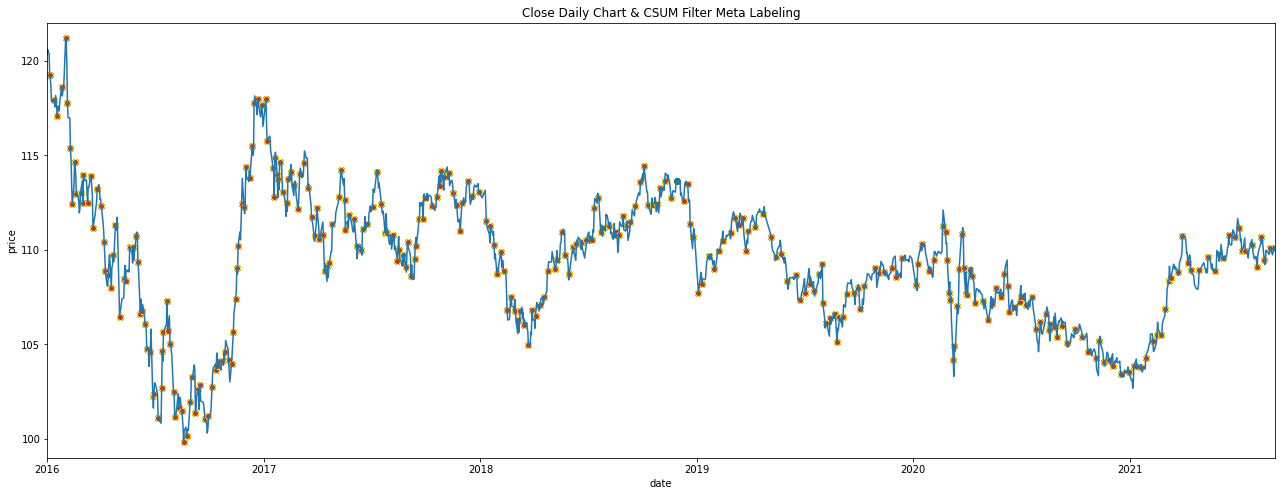

In [218]:
side = labels.bin
print("side:")
print(side)
#print(type(side))

# トリプルバリアのイベントを取得する
events_meta = getEvents(close,tEvents,ptsl,target,minRate,cpus,t1=t1,side=side)
#print("events_meta:")
#print(events_meta)

# 売買の方向を示す　メタラベリングがないパターン
labels_meta = getBins(events_meta,close)
#print("labels_meta:")
#print(labels_meta)

clean_labels_meta = dropLabels(labels_meta,minPct)
#print("clean_labels_meta:")
#print(clean_labels_meta)

clean_labels_done = clean_labels_meta.query('bin == 1.0')
evnet_price_done = close[close.index.isin(clean_labels_done.index)]
#print("evnet_price_done:")
#print(evnet_price_done)

print("cusum event:" + str(len(cusum_price.index)))
print("buy   event:" + str(len(event_price_buy.index)))
print("sell  event:" + str(len(event_price_sell.index)))
print("done  event:" + str(len(evnet_price_done.index)))

plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.scatter(cusum_price.index, cusum_price[:],edgecolors="green")
plt.scatter(event_price_buy.index, event_price_buy[:],edgecolors="red")
plt.scatter(event_price_sell.index, event_price_sell[:],edgecolors="blue")
plt.scatter(evnet_price_done.index, evnet_price_done[:],edgecolors="yellow")
plt.title("Close Daily Chart & CSUM Filter Meta Labeling")
plt.xlabel('date')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.ylabel('price')

plt.show()

##4. 移動平均のゴールデンクロスとデットクロスをラベルとして使用したメタラベリング

**移動平均の売買シグナルをラベルとしてメタラベリングして売買しないかを判断する**

###4.1 移動平均のゴールデンクロスとデットクロスのラベル

移動平均の売買シグナルをラベルとしてメタラベリングして売買しないかを判断する

In [223]:

def  getSMACrossLabel(close, short_window, long_window ):
  sma_short = pd.Series.rolling(close, window = short_window).mean()
  sma_long  = pd.Series.rolling(close, window = long_window).mean()

  close = close[ long_window: ]
  sma_short = sma_short[ long_window: ]
  sma_long = sma_long[ long_window: ]

  #ゴールデンクロス、デッドクロスを見つける
  cross  = sma_short > sma_long
  golden = (cross != cross.shift(1)) & (cross == True)
  dead   = (cross != cross.shift(1)) & (cross == False)

  #buy 1
  golden_date = golden[golden[:] == True]
  golden_date = golden_date.replace(True,1)
  
  #sell -1
  dead_date = dead[dead[:] == True]
  dead_date = dead_date.replace(True,-1) 
  
  gcvalue = pd.concat([golden_date, dead_date])
  gcvalue = gcvalue.sort_index()  
  sma_short = sma_short[sma_short.index.isin(gcvalue.index)]
  sma_long = sma_long[sma_long.index.isin(gcvalue.index)]


  df = pd.DataFrame({'ret': sma_short[:]- sma_long[:],
                    'bin': gcvalue[:]},
                     index=gcvalue.index)


  #print(df) 
  return df

In [224]:
labes_sma = getSMACrossLabel(close, 10,15)
print('labes_sma:')
print(labes_sma)
print(type(labes_sma))


labes_sma:
                 ret  bin
2002-04-22 -0.526667 -1.0
2002-06-14  0.060000  1.0
2002-06-25 -0.126667 -1.0
2002-07-31  0.243333  1.0
2002-08-16 -0.056667 -1.0
...              ...  ...
2021-06-03  0.002333  1.0
2021-07-12 -0.015000 -1.0
2021-08-17  0.015333  1.0
2021-08-25 -0.030333 -1.0
2021-09-01  0.039667  1.0

[372 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


numDays:1
target:
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2002-04-22', '2002-06-14', '2002-06-25', '2002-07-31',
               '2002-08-16', '2002-08-30', '2002-09-06', '2002-09-17',
               '2002-11-01', '2002-11-26',
               ...
               '2021-01-29', '2021-02-01', '2021-04-15', '2021-05-11',
               '2021-05-28', '2021-06-03', '2021-07-12', '2021-08-17',
               '2021-08-25', '2021-09-01'],
              dtype='datetime64[ns]', length=372, freq=None)
close    event:4762
sma      event:372
buy sma  event:186
sell sma event:186
sma_done event:180


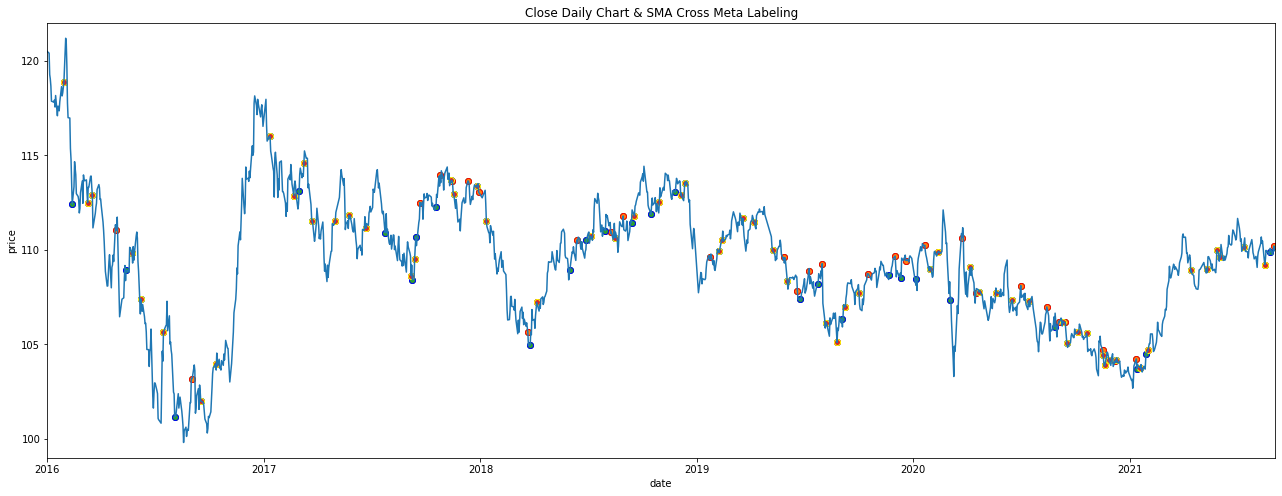

In [229]:
clean_labels_sma = labes_sma
evnet_price_sma = close[close.index.isin(clean_labels_sma.index)]
#print("evnet_price_sma:")
#print(evnet_price_sma)

print("numDays:" + str(numDays))

evnet_price_sma = evnet_price_sma.dropna()
tEvents_sma = evnet_price_sma.index
#print("tEvents_sma:")
#print(tEvents_sma)
#print(type(tEvents_sma))

# 日次ボラティリティを計算する
target_sma = getDailyVol(close)

side_sma = labes_sma.bin
#print("side_sma:")
#print(side_sma)
#print(type(side.loc[target_sma.index]))
#print(type(side_sma.loc[target_sma.index]))

ptsl_sma = [1,1]
# 垂直バリアの情報を追加する
t1_sma = addVerticalBarrier(tEvents,close,numDays=numDays)

# トリプルバリアのイベントを取得する
events_sma_meta = getEvents(close,tEvents_sma,ptsl_sma,target_sma,minRate,cpus,t1=t1_sma,side=side_sma)
#print("events_sma_meta:")
#print(events_sma_meta)

# 売買の方向を示す　メタラベリングがないパターン
labels_sma_meta = getBins(events_sma_meta,close)

clean_labels_sma_meta = dropLabels(labels_sma_meta,minPct)
#print("clean_labels_sma_meta:")
#print(clean_labels_sma_meta)

clean_labels_sma_done = clean_labels_sma_meta.query('bin == 1.0')
evnet_price_sma_done = close[close.index.isin(clean_labels_sma_done.index)]

clean_labels_sma_buy = clean_labels_sma.query('bin == 1')
event_price_sma_buy = close[close.index.isin(clean_labels_sma_buy.index)]
#print("event_price_sma_buy:")
#print(event_price_sma_buy)

clean_labels_sma_sell = clean_labels_sma.query('bin == -1')
event_price_sma_sell = close[close.index.isin(clean_labels_sma_sell.index)]
#print("event_price_sma_sell:")
#print(event_price_sma_sell)

print("close    event:" + str(len(close.index)))
print("sma      event:" + str(len(evnet_price_sma.index)))
print("buy sma  event:" + str(len(event_price_sma_buy.index)))
print("sell sma event:" + str(len(event_price_sma_sell.index)))
print("sma_done event:" + str(len(evnet_price_sma_done.index)))

plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.scatter(evnet_price_sma.index, evnet_price_sma[:],edgecolors="green")
plt.scatter(event_price_sma_buy.index, event_price_sma_buy[:],edgecolors="red")
plt.scatter(event_price_sma_sell.index, event_price_sma_sell[:],edgecolors="blue")
plt.scatter(evnet_price_sma_done.index, evnet_price_sma_done[:],edgecolors="yellow")

plt.title("Close Daily Chart & SMA Cross Meta Labeling")
plt.xlabel('date')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.ylabel('price')

plt.show()